## Languages of the countries of the world

Welcome to this notebook, where we will be analyzing the diversity of languages in the countries of the world. We will be working with a dataset accessed through wikipedia, originating from ethnologue (https://web.archive.org/web/20190428174546/https://www.ethnologue.com/statistics/country). This dataset will be combined with a dataset containing more general country statistics accessed through Kaggle https://www.kaggle.com/datasets/fernandol/countries-of-the-world.

The data will be analyzed with the aim of elaboration on the following questions:


- In which countries are the most respectively least number of languages spoken?
- How does linguistic diversity distribute itself over the regions of the world?
- How well does the number of languages in a country correlate with its lingusitic diversity?
- Which country variables can best predict linguistic diversity, if any at all?
- How is the data on linguistic diversiy clustered?



Lets start by importing our four riders of the apocalypse:

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

Now we proceed with installing our datasets

In [113]:
Tables = pd.read_html('https://web.archive.org/web/20190428174546/https://www.ethnologue.com/statistics/country')

As there are multiple tables on the website, we will import them all and have to select the one that we are looking for:

In [114]:
len(Tables)

3

In [115]:
print(Tables[0], Tables[1], Tables[2])


      0     1     2
0   Feb   APR   Sep
1   NaN    28   NaN
2  2017  2019  2020                Country Living languages                                \
               Country            Count Percent Established Immigrant   
0          Afghanistan               42    0.59          41         1   
1        Aland Islands                3    0.04           3         0   
2              Albania               12    0.17           8         4   
3              Algeria               22    0.31          18         4   
4       American Samoa                7    0.10           2         5   
..                 ...              ...     ...         ...       ...   
237  Wallis and Futuna                3    0.04           3         0   
238     Western Sahara                4    0.06           3         1   
239              Yemen               17    0.24          11         6   
240             Zambia               55    0.77          46         9   
241           Zimbabwe               24    0

We see that the second table contains the values for countries, languages and diversty, so lets go ahead and save it away as our dataframe and have a first look.

In [116]:
lingo = Tables[1]

In [117]:
lingo.head()

Country Living languages                                \
          Country            Count Percent Established Immigrant   
0     Afghanistan               42    0.59          41         1   
1   Aland Islands                3    0.04           3         0   
2         Albania               12    0.17           8         4   
3         Algeria               22    0.31          18         4   
4  American Samoa                7    0.10           2         5   

  Number of speakers                 Diversity           
               Total     Mean Median     Index Coverage  
0           23352300   569568  16500     0.796      98%  
1              27652     9217   1450     0.100     100%  
2            2847936   284794   9820     0.518      83%  
3           38548160  1927408  40000     0.511      91%  
4              56090     9348  25890     0.215      86%

In [118]:
lingo.shape

(242, 10)

In [119]:
print(lingo.columns)

lingo.columns.values

MultiIndex([(           'Country',     'Country'),
            (  'Living languages',       'Count'),
            (  'Living languages',     'Percent'),
            (  'Living languages', 'Established'),
            (  'Living languages',   'Immigrant'),
            ('Number of speakers',       'Total'),
            ('Number of speakers',        'Mean'),
            ('Number of speakers',      'Median'),
            (         'Diversity',       'Index'),
            (         'Diversity',    'Coverage')],
           )


array([('Country', 'Country'), ('Living languages', 'Count'),
       ('Living languages', 'Percent'),
       ('Living languages', 'Established'),
       ('Living languages', 'Immigrant'), ('Number of speakers', 'Total'),
       ('Number of speakers', 'Mean'), ('Number of speakers', 'Median'),
       ('Diversity', 'Index'), ('Diversity', 'Coverage')], dtype=object)

So, all in all we have 242 rows and 10 columns. Now, looking at the columns, we see that the dataframe is MultiIndex, which means that each column contains a dataframe with columns. This is something we would rather avoid, and as such we turn it into a single index dataframe.

In [120]:
new_columns_names = ['country', 'lang_count', 'lang_count(%)', 'lang_count_established', 'lang_count_immigrant', 'nmb_of_speakers_total', 'nmb_of_speakers_mean', 'nmb_of_speakers_median', 'diversity_index', 'diversity_coverage']

lingo.columns = new_columns_names

Before moving on, lets give a brief overview of the columns in the dataset:

- Country: Name of the country being studied.

- lang_count: The number of languages found in a given country

- lang_count(%): Percentage of the worlds languages that are found in a given country

- lang_count_established/immigrant: These two columns signal how many of the languages in a given country are established, having been in the country for a long time, and immigrant, being recently introduced through immigration.

- nmb_of_speakers_total/mean/median: These three columns gives the total meand and median number of speakers of any language in a given country

- diveristy_index: Contains the diversity index of a given country, by its Greenberg's diversity index, which is the probability of two random speakers in a given country speak different languages as mother language.

- diversity_coverage: Gives the percentage of the population for which estimates of number of speakers are given. A higher values thus means that the diversity index is calculated based on more complete data


Lets now get a some more info on how the dataset actually looks.

In [121]:
lingo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 242 non-null    object 
 1   lang_count              242 non-null    int64  
 2   lang_count(%)           242 non-null    float64
 3   lang_count_established  242 non-null    int64  
 4   lang_count_immigrant    242 non-null    int64  
 5   nmb_of_speakers_total   242 non-null    int64  
 6   nmb_of_speakers_mean    242 non-null    int64  
 7   nmb_of_speakers_median  242 non-null    int64  
 8   diversity_index         242 non-null    object 
 9   diversity_coverage      242 non-null    object 
dtypes: float64(1), int64(6), object(3)
memory usage: 19.0+ KB


We see that there are no null values, but diversity index and coverege are non_numeric, which they should be. So lets first make them numeric

In [122]:
lingo['diversity_index'] = pd.to_numeric(lingo['diversity_index'], errors='coerce')
lingo.diversity_coverage = lingo.diversity_coverage.replace("%", "", regex=True)
lingo['diversity_coverage'] = pd.to_numeric(lingo['diversity_coverage'], errors='coerce')

lingo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 242 non-null    object 
 1   lang_count              242 non-null    int64  
 2   lang_count(%)           242 non-null    float64
 3   lang_count_established  242 non-null    int64  
 4   lang_count_immigrant    242 non-null    int64  
 5   nmb_of_speakers_total   242 non-null    int64  
 6   nmb_of_speakers_mean    242 non-null    int64  
 7   nmb_of_speakers_median  242 non-null    int64  
 8   diversity_index         239 non-null    float64
 9   diversity_coverage      242 non-null    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 19.0+ KB


We see that some missing values appeared in the diversity index when converting the data to numeric. We will go ahead and fill it in with the average value of the column

In [123]:
lingo['diversity_index'][lingo['diversity_index'].isnull()] = lingo['diversity_index'].mean()

/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_98147/1211858122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lingo['diversity_index'][lingo['diversity_index'].isnull()] = lingo['diversity_index'].mean()


Now what we will go ahead and do is to import our other datatable with the country statistic and merge it with our current language dataframe

In [124]:
Country_stats = pd.read_csv('countries of the world.csv')

In [125]:
Country_stats.head

<bound method NDFrame.head of              Country                               Region  Population  \
0       Afghanistan         ASIA (EX. NEAR EAST)             31056997   
1           Albania   EASTERN EUROPE                          3581655   
2           Algeria   NORTHERN AFRICA                        32930091   
3    American Samoa   OCEANIA                                   57794   
4           Andorra   WESTERN EUROPE                            71201   
..               ...                                  ...         ...   
222       West Bank   NEAR EAST                               2460492   
223  Western Sahara   NORTHERN AFRICA                          273008   
224           Yemen   NEAR EAST                              21456188   
225          Zambia   SUB-SAHARAN AFRICA                     11502010   
226        Zimbabwe   SUB-SAHARAN AFRICA                     12236805   

     Area (sq. mi.) Pop. Density (per sq. mi.) Coastline (coast/area ratio)  \
0            6

In [126]:
Country_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Country                             227 non-null    object 
 1   Region                              227 non-null    object 
 2   Population                          227 non-null    int64  
 3   Area (sq. mi.)                      227 non-null    int64  
 4   Pop. Density (per sq. mi.)          227 non-null    object 
 5   Coastline (coast/area ratio)        227 non-null    object 
 6   Net migration                       224 non-null    object 
 7   Infant mortality (per 1000 births)  224 non-null    object 
 8   GDP ($ per capita)                  226 non-null    float64
 9   Literacy (%)                        209 non-null    object 
 10  Phones (per 1000)                   223 non-null    object 
 11  Arable (%)                          225 non-n

We see that there are some missing values for the dataframe, what we will do is to fill them in with the average of the column they are in and turn any stringrepresentations of numeric values into numerics.

In [127]:
Country_stats.replace(',', '.', regex=True, inplace=True)
for col in Country_stats.columns[2:]:
    Country_stats[col] = pd.to_numeric(Country_stats[col], errors='coerce')
    Country_stats[col][Country_stats[col].isnull()] = Country_stats[col].mean()
    

/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_98147/1502337870.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Country_stats[col][Country_stats[col].isnull()] = Country_stats[col].mean()
/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_98147/1502337870.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Country_stats[col][Country_stats[col].isnull()] = Country_stats[col].mean()
/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_98147/1502337870.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

In [183]:
Country_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   country                             227 non-null    object 
 1   Region                              227 non-null    object 
 2   Population                          227 non-null    int64  
 3   Area (sq. mi.)                      227 non-null    int64  
 4   Pop. Density (per sq. mi.)          227 non-null    float64
 5   Coastline (coast/area ratio)        227 non-null    float64
 6   Net migration                       227 non-null    float64
 7   Infant mortality (per 1000 births)  227 non-null    float64
 8   GDP ($ per capita)                  227 non-null    float64
 9   Literacy (%)                        227 non-null    float64
 10  Phones (per 1000)                   227 non-null    float64
 11  Arable (%)                          227 non-n

In [184]:
Country_stats

,country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.060000,163.070000,700.000000,36.000000,3.200000,12.13,0.22,87.65,1.0,46.600000,20.340000,0.380000,0.240000,0.380000
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.930000,21.520000,4500.000000,86.500000,71.200000,21.09,4.42,74.49,3.0,15.110000,5.220000,0.232000,0.188000,0.579000
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.390000,31.000000,6000.000000,70.000000,78.100000,3.22,0.25,96.53,1.0,17.140000,4.610000,0.101000,0.600000,0.298000
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.710000,9.270000,8000.000000,97.000000,259.500000,10.00,15.00,75.00,2.0,22.460000,3.270000,0.150844,0.282711,0.565283
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.600000,4.050000,19000.000000,100.000000,497.200000,2.22,0.00,97.78,3.0,8.710000,6.250000,0.150844,0.282711,0.565283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,419.9,0.00,2.980000,19.620000,800.000000,82.838278,145.200000,16.90,18.97,64.13,3.0,31.670000,3.920000,0.090000,0.280000,0.630000
223,Western Sahara,NORTHERN AFRICA,273008,266000,1.0,0.42,0.038125,35.506964,9689.823009,82.838278,236.061435,0.02,0.00,99.98,1.0,22.114732,9.241345,0.150844,0.282711,0.400000
224,Yemen,NEAR EAST,21456188,527970,40.6,0.36,0.000000,61.500000,800.000000,50.200000,37.200000,2.78,0.24,96.98,1.0,42.890000,8.300000,0.135000,0.472000,0.393000
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,15.3,0.00,0.000000,88.290000,800.000000,80.600000,8.200000,7.08,0.03,92.90,2.0,41.000000,19.930000,0.220000,0.290000,0.489000


I won't go into depth explaining the columns in this dataframe, as they are fairly common knowledge and the columns pretty much speak for themselves. Population is the population of the countr, GDP per capity is the GDP per capita of the country. The last three columns however might need some clarification. They contains how many percentage of the employed persons in the country are active in which economical sector: Agriculture, Industry or service. 


Now we can go ahead and merge the dataframes. The key value that we want to index on, the name of the country, has an ampty space as part of thes tring after the name in our Country_stats dataset. We therefore have to remove this so that the columns are indentical. Furthermore, our linguistic diversity dataset has more rows, signalling it has included more places than just countries, such as autonomous regions. We will therefore do an innerjoin, making sure that only the countries present in both dataset is part of the final dataset.

In [129]:
Country_stats.rename(columns={'Country':'country'}, inplace=True)
i = 0
for x in Country_stats.country:
    Country_stats.loc[i,'country'] = Country_stats.loc[i,'country'][0:-1]
    i +=1


df = pd.merge(Country_stats, lingo, on='country', how = 'inner')

Okay, now we have our final data set. Lets do a quick inspection and then proceed with some plots :)

In [130]:
df.head(10)

,country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),...,Service,lang_count,lang_count(%),lang_count_established,lang_count_immigrant,nmb_of_speakers_total,nmb_of_speakers_mean,nmb_of_speakers_median,diversity_index,diversity_coverage
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,...,0.380000,42,0.59,41,1,23352300,569568,16500,0.796,98
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,...,0.579000,12,0.17,8,4,2847936,284794,9820,0.518,83
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,...,0.298000,22,0.31,18,4,38548160,1927408,40000,0.511,91
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,...,0.565283,7,0.10,2,5,56090,9348,25890,0.215,86
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,...,0.565283,5,0.07,4,1,73500,18375,19650,0.664,80
5,Angola,SUB-SAHARAN AFRICA,12127071,1246700,9.7,0.13,0.00,191.19,1900.0,42.0,...,0.246000,47,0.66,46,1,24288770,528017,30000,0.745,98
6,Anguilla,LATIN AMER. & CARIB,13477,102,132.1,59.80,10.76,21.03,8600.0,95.0,...,0.780000,2,0.03,2,0,12450,6225,6225,0.141,100
7,Argentina,LATIN AMER. & CARIB,39921833,2766890,14.4,0.18,0.61,15.18,11200.0,97.1,...,0.547000,40,0.56,24,16,46160150,1318861,5120,0.155,88
8,Armenia,C.W. OF IND. STATES,2976372,29800,99.9,0.00,-6.47,23.28,3500.0,98.6,...,0.418000,14,0.20,8,6,3036180,276016,8850,0.049,79
9,Aruba,LATIN AMER. & CARIB,71891,193,372.5,35.49,0.00,5.89,28000.0,97.0,...,0.663000,6,0.08,4,2,86790,21698,7000,0.484,67


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   country                             195 non-null    object 
 1   Region                              195 non-null    object 
 2   Population                          195 non-null    int64  
 3   Area (sq. mi.)                      195 non-null    int64  
 4   Pop. Density (per sq. mi.)          195 non-null    float64
 5   Coastline (coast/area ratio)        195 non-null    float64
 6   Net migration                       195 non-null    float64
 7   Infant mortality (per 1000 births)  195 non-null    float64
 8   GDP ($ per capita)                  195 non-null    float64
 9   Literacy (%)                        195 non-null    float64
 10  Phones (per 1000)                   195 non-null    float64
 11  Arable (%)                          195 non-n

In [132]:
df.describe()

,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),...,Service,lang_count,lang_count(%),lang_count_established,lang_count_immigrant,nmb_of_speakers_total,nmb_of_speakers_mean,nmb_of_speakers_median,diversity_index,diversity_coverage
count,1.950000e+02,1.950000e+02,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,1.950000e+02,1.950000e+02,1.950000e+02,195.000000,195.000000
mean,3.094257e+07,5.827088e+05,281.723590,15.257795,0.192689,36.147082,9907.640118,82.263774,229.089465,13.913304,...,0.559002,50.856410,0.715641,42.082051,8.774359,3.340699e+07,5.989039e+05,1.063905e+05,0.432547,87.143590
std,1.264939e+08,1.507890e+06,1285.607661,41.616850,4.550125,35.979141,10362.268686,19.430795,226.530391,13.536695,...,0.155047,103.455304,1.454643,100.945343,15.918943,1.348912e+08,1.011439e+06,4.355498e+05,0.295990,12.740466
min,7.502000e+03,2.000000e+00,0.000000,0.000000,-20.710000,2.290000,500.000000,17.600000,1.300000,0.000000,...,0.062000,1.000000,0.010000,1.000000,0.000000,3.920000e+03,1.722000e+03,1.000000e+01,0.000000,50.000000
25%,5.133195e+05,1.299500e+04,27.100000,0.095000,-0.850000,8.340000,2000.000000,72.400000,38.500000,3.020000,...,0.443500,9.000000,0.130000,4.000000,1.000000,6.117500e+05,6.396600e+04,6.975000e+03,0.158000,80.000000
50%,5.548702e+06,1.088900e+05,74.000000,0.630000,0.000000,21.290000,5400.000000,90.700000,153.800000,10.380000,...,0.565283,23.000000,0.320000,13.000000,4.000000,6.322800e+06,2.847940e+05,2.310000e+04,0.443000,91.000000
75%,1.796809e+07,4.691400e+05,176.300000,7.390000,0.905000,55.900000,16250.000000,97.850000,338.500000,21.025000,...,0.665500,45.000000,0.630000,30.500000,8.000000,1.873582e+07,6.168810e+05,6.605000e+04,0.702500,98.000000
max,1.313974e+09,9.984670e+06,16271.500000,331.660000,23.060000,191.190000,55100.000000,100.000000,1035.600000,62.110000,...,0.954000,840.000000,11.810000,840.000000,116.000000,1.319419e+09,8.627658e+06,5.700000e+06,0.988000,100.000000



Now we have merged our datasets, cleaned the data and have gotten a very rough idea of what our data looks like

Lets continue by diving into our most important variables, beginning with the number of languages under *lang_count*

23.0


Text(0, 0.5, 'number of languages')

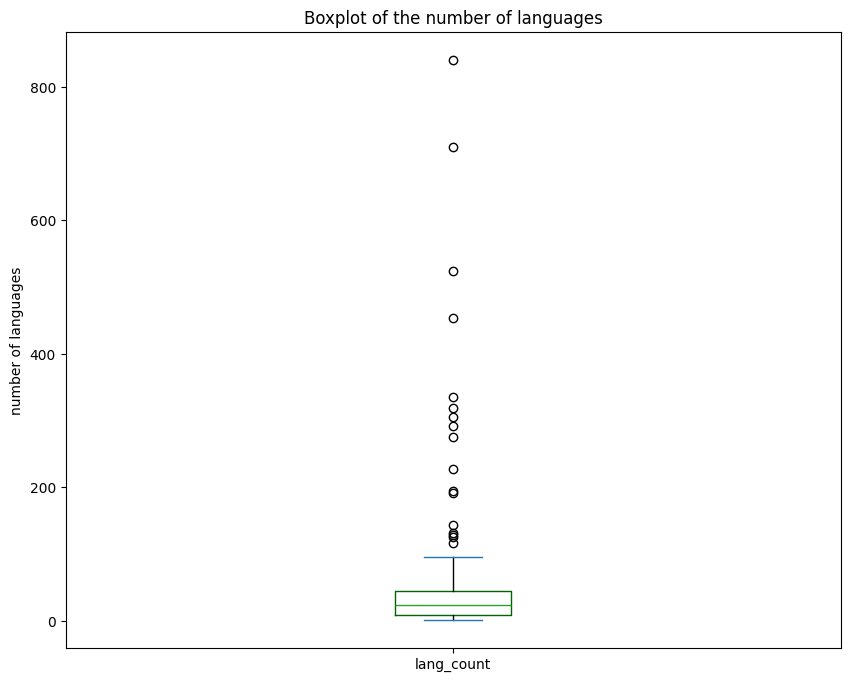

In [147]:
df.lang_count.plot(figsize = (10,8),
        kind = 'box',
        title = 'Boxplot of the number of languages',
        color = dict(boxes = 'darkgreen', whiskers = 'black'),
        
)
print(df.lang_count.median())
plt.ylabel('number of languages')



The boxplot reveals that the distribution of language count is heavily skewed to the right, meaning that in most countries, very few languages are spoken. On average(*median*) 23 langauges are spoken in each country. But some countries representing outliers have more than 800 languages spoken. Lets have another look at the distribution by plotting it as a histogram. 

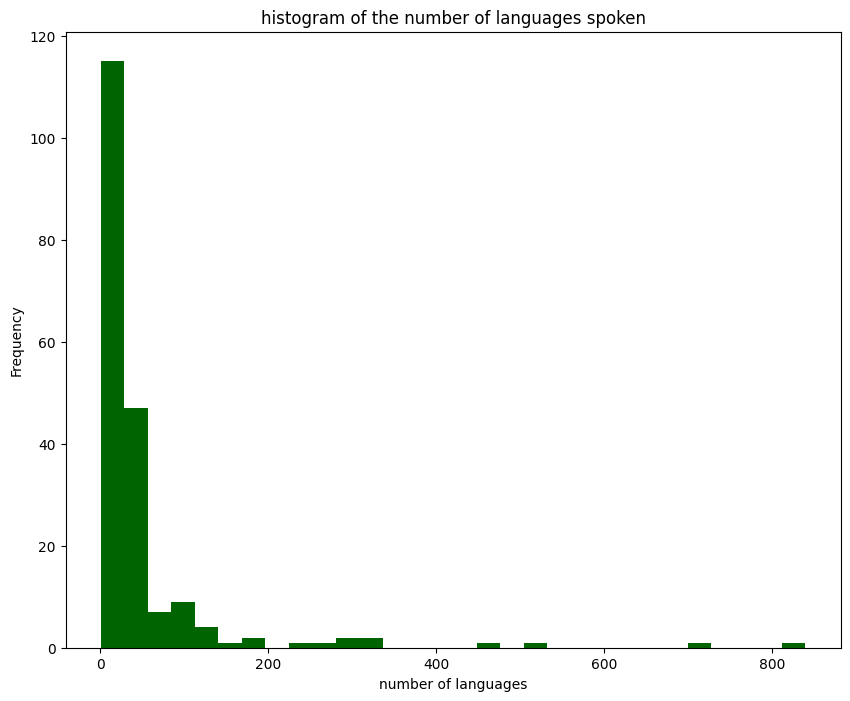

In [161]:
df.lang_count.plot(figsize=(10,8),
    kind = 'hist',
    color = 'darkgreen',
    title = 'histogram of the number of languages spoken',
    bins = 30
)
plt.xlabel('number of languages');

Here we see clearly see the heavy right skew. Lets see how the disribution looks if we filter out outliers with more than 150 languages.

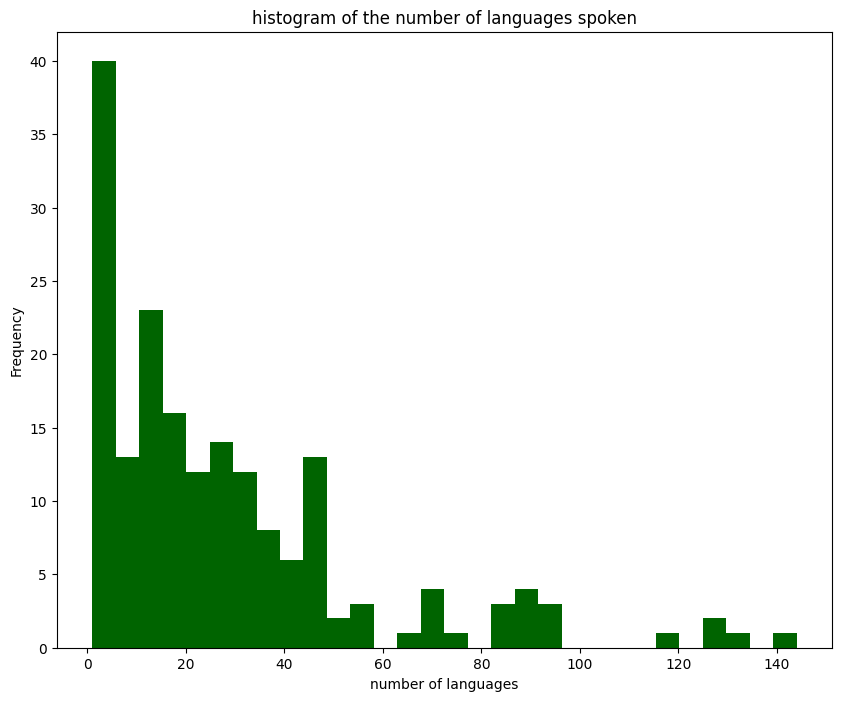

In [163]:
df.lang_count[df.lang_count < 150].plot(figsize=(10,8),
    kind = 'hist',
    color = 'darkgreen',
    title = 'histogram of the number of languages spoken',
    bins = 30
)
plt.xlabel('number of languages');

Now we see really clearly see the distribution with most countries having few languages, and from about 40 languages and upwards, the distribution is verys spread.

Now lets move on by takeing a look at which countries has the most respectively least number of languages.

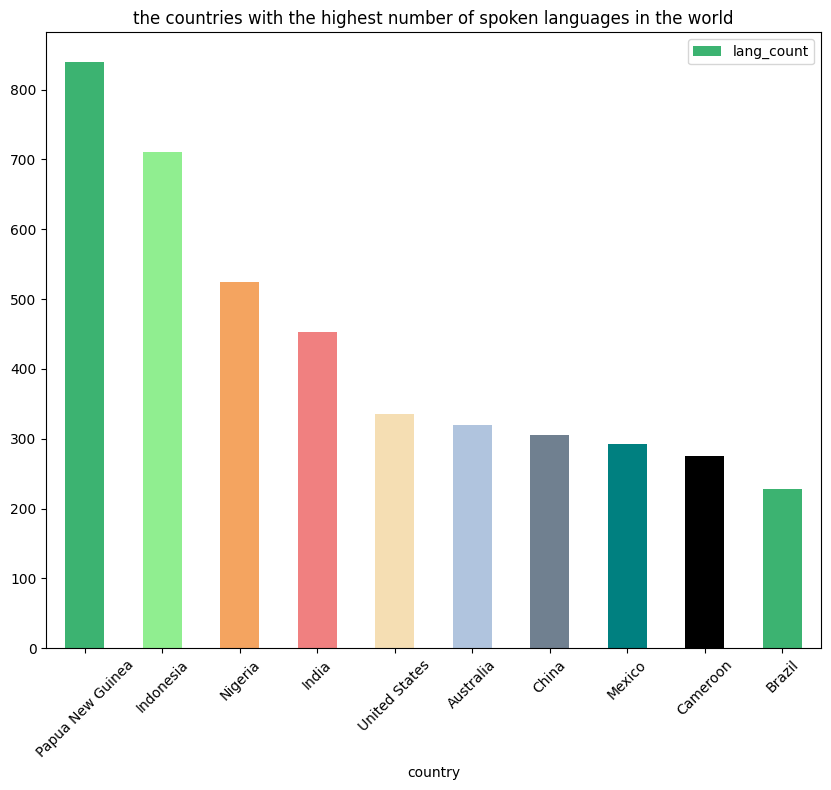

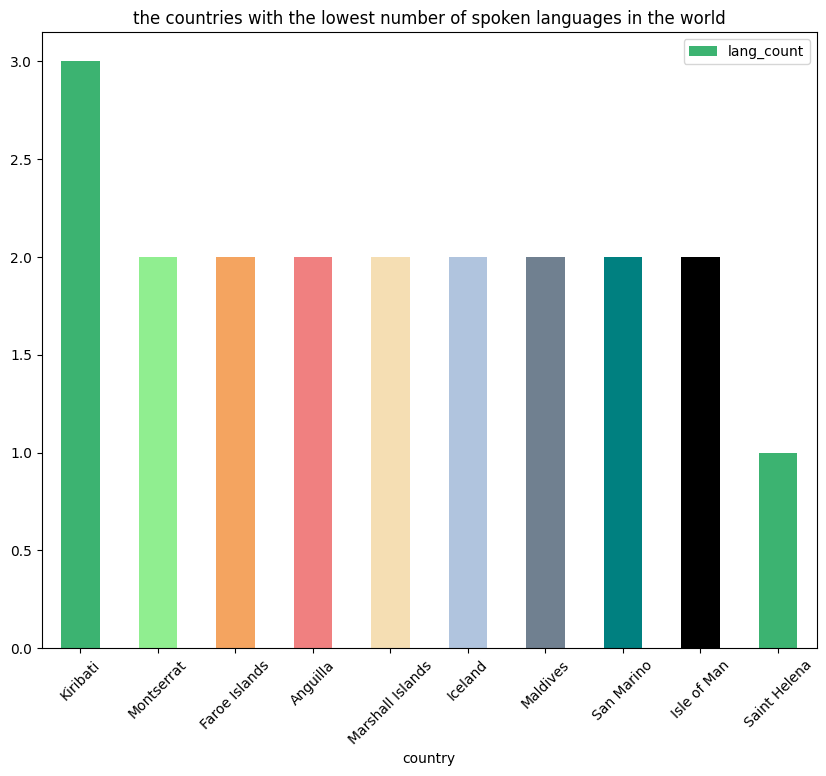

In [193]:
df.sort_values(by='lang_count', ascending=False).head(10).plot(figsize = (10,8),
    x = 'country',
    y = 'lang_count',
    kind = 'bar',
    rot = 45,
    color= ['mediumseagreen','lightgreen','sandybrown','lightcoral','wheat','lightsteelblue','slategrey','teal','black'],
    title= "the countries with the highest number of spoken languages in the world"
);

df.sort_values(by='lang_count', ascending=False).tail(10).plot(figsize = (10,8),
    x = 'country',
    y = 'lang_count',
    kind = 'bar',
    rot = 45,
    color= ['mediumseagreen','lightgreen','sandybrown','lightcoral','wheat','lightsteelblue','slategrey','teal','black'],
    title= "the countries with the lowest number of spoken languages in the world"
);

Now, just looking at the head and tail, quite some valueable insights are given. From the countries with the most languages, we find some notable names, like the USA, India, China and Brazil. Countries that are some of the most powerful and well known in the world. But looking at the countries with the lowest number of langauges spoken, just one to 3 languages, we find microstates with 9 out of 10 being islands.

Now, lets move on to looking at linguistic diversity.

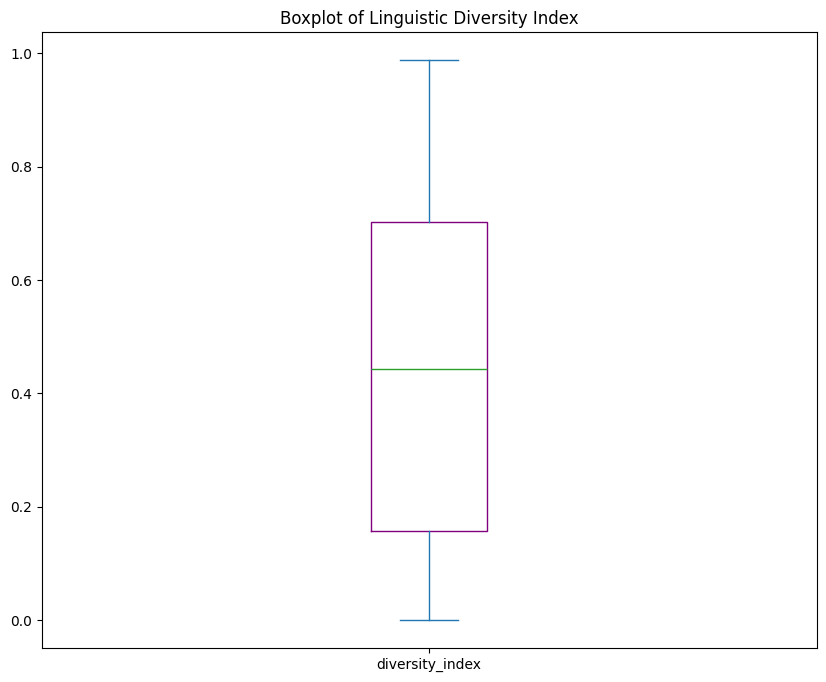

In [ ]:
df.diversity_index.plot(figsize=(10,8),
    kind = 'box',
    title = 'Boxplot of Linguistic Diversity Index',
    color=dict(boxes='Purple')
    );


The Boxplot for the linguistic diversity index is very neat, showing a median at a little below 0.5 and a very evenly sized quartiles. One can notice a very very slight right tail skew however. Lets go ahead and also look at its histogram.

<Axes: ylabel='Frequency'>

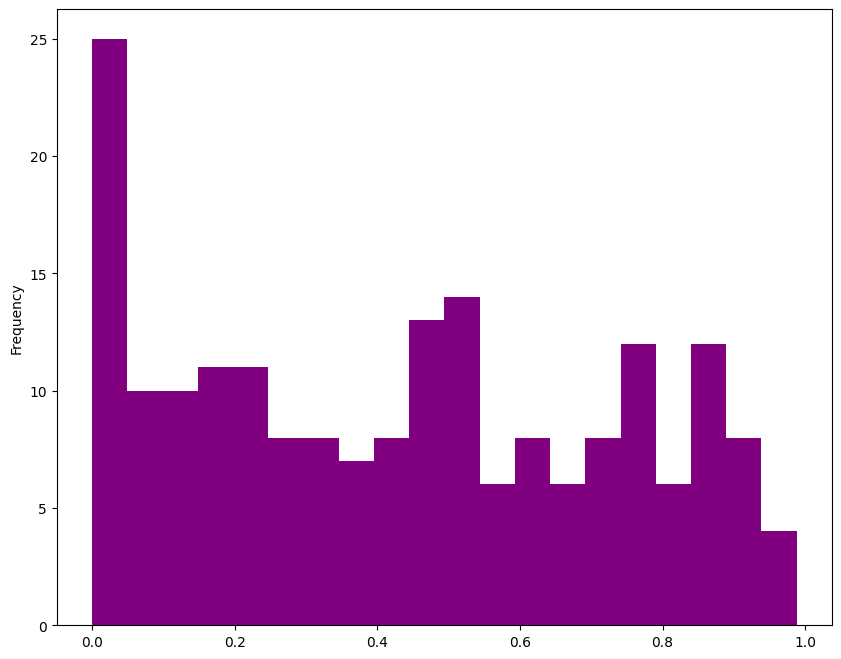

In [ ]:
df.diversity_index.plot(figsize = (10,8),
        kind = 'hist',
        color = 'purple', 
        bins = 20       
);

We see here, that just as with the number of languages, there are many languages that have very little diversity, but still the distribution is far more even. It is logical to assume that in countries with many languages, the linguistic diversity is high, but this most not necessarily be the fact, as many of the languages could have very few speakers, with just one language being spoken by a clear majority. The discrepancy in the distribution hint towards this being true for the data, but lets plot the two variables against eachother for a better look.


0.31892856656122925 5.514554029954722e-06


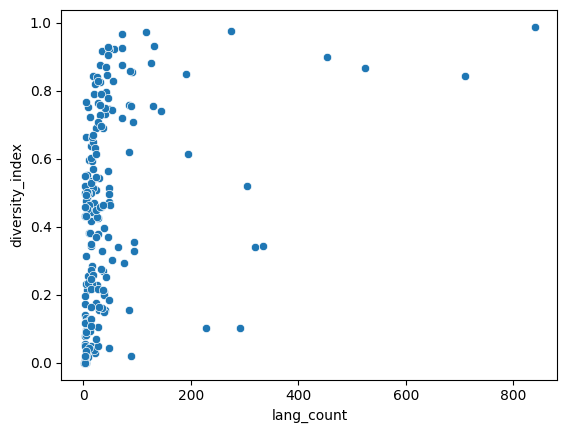

In [207]:
import scipy.stats as stats
ax = sns.scatterplot(x ='lang_count', y = 'diversity_index', data = df)
ax.set_title = 'Linguistic diversity vs language count'
r, p = stats.pearsonr(df['lang_count'], df['diversity_index'])
print(r, p)



Looking at the plot, and considering the calculated r-value, there is indeed a correlation, albeit weak, r = 0.32
Now this plot has included the outliers, so lets do the same thing, but without the outliers that are skewing the analysis.

0.31892856656122925 5.514554029954722e-06


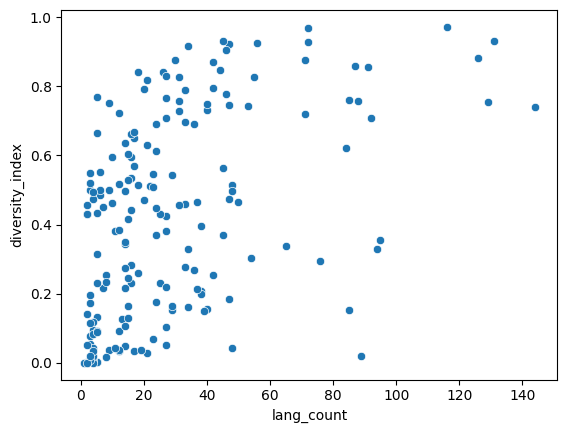

In [210]:
filter = df['lang_count'] < 150
filtered_LC = df['lang_count'][filter]
filtered_DI = df['diversity_index'][filter]
ax_filtered= sns.scatterplot(x =filtered_LC, y = filtered_DI)
ax_filtered.set_title = 'Linguistic diversity vs language count without outliers'
r, p = stats.pearsonr(df['lang_count'], df['diversity_index'])
print(r, p)

Looking at the graph without the outliers, the correlation is more clearly visible, but the strenth is still weak to moderate with r = 0.32. To conclude: A realtionship does indeed exists between the number of languages spoken in a country and its lingusitic diversity, but it doesn't tell the entire tale. 

Okay, now lets try to get an idea of what the geographical distribution looks. We will start by plotting box plots by region to get an overview.

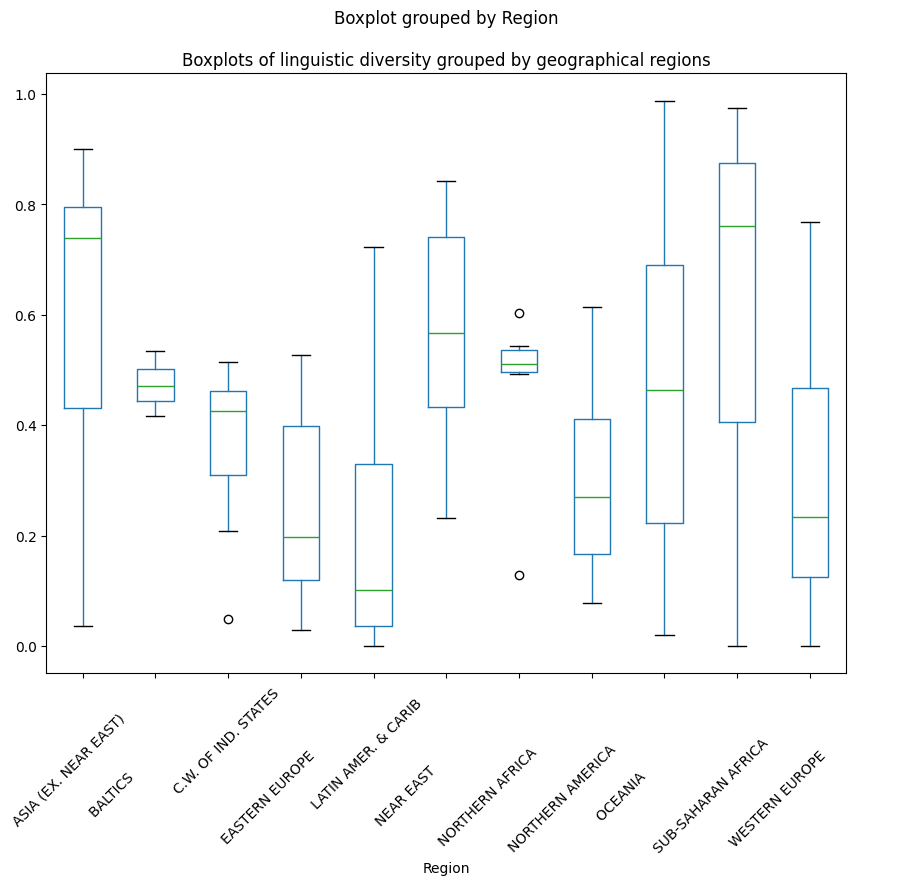

In [226]:
df.boxplot(figsize=(10,8),
    column='diversity_index',
     by= 'Region',
     grid= False,
     rot = 45,
     
);
plt.title('Boxplots of linguistic diversity grouped by geographical regions');


Looking at the boxplots, we can clearly identify two regions as the most linguistically divers, namely Asia, excluding the middle east, and sub-saharan Africa. Both of these regions have very high medians, between 0,7 and 0,8, while the regions with lowest linguistic diversity proves to be europe and north america. Note here, that the region 'C.W. of Ind. States' consistutes of the countries that once was part of the U.S.S.R, as this might not be intuitive. 

Another interesting region in this context is oceania, as it covers more or less the entire index, but its mean is a low compared to Asia and sub-saharan Africa. Find find it at between 0.4 and 0.5, and as such, it seems to be a region that is home to countries with both high and low linguistic diversity.

To give an even better Idea of the the geographical distribution of linguistic diversity, and to sum up this inital exploratory data analysis, we will creating a world map with our countries, coloring in the countries depending on their degree of linguistic diversity from 0 to 1. 